In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import scipy.stats as stats

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
my_data = pd.read_csv('/home/lin/教材/Financial_data/FinalTest/Dataset.csv')

In [3]:
my_data.head()

,S1,S2,S3
0,42.10,23.80,46.05
1,44.20,23.80,45.92
2,44.94,23.57,46.14
3,44.86,23.58,46.07
4,43.64,23.29,44.09


In [10]:
logR = np.log(my_data).diff().dropna()

## Q 1

In [15]:
logR.describe().iloc[:3]

,S1,S2,S3
count,2499.000000,2499.000000,2499.000000
mean,0.000206,-0.000182,-0.000565
std,0.045696,0.031346,0.054522


## Skewness for three stocks

In [13]:
stats.skew(logR)

array([-3.73482945e-03, -4.64590384e+00, -5.24419564e-01])

## Kurtosis for three stocks

In [17]:
stats.kurtosis(logR) + 3

array([ 21.88308304, 131.78438552,  38.2654605 ])

## Comments

Skewness are negative which means more returns are negative while normal distribution is symetric. 

Kurtosis are way higher than 3 indicating fatter tails than normal with 3 as kurtosis. However, the fourth moments may not be defined which means kurtosis may eventually goes to infinity.

## Q 2

In [43]:
sort_LR = pd.DataFrame(columns=logR.columns, dtype=float)

for col in logR:
    sort_LR[col] = logR[col].sort_values().values
sort_LR.reset_index(inplace=True, drop=True)

In [106]:
def HS_var_ES(data, alpha_one, alpha_two, alpha_es):
    ind_var_one = int( data.size * (1-alpha_one))-1
    ind_var_two = int( data.size * (1-alpha_two))-1
    ind_es = int( data.size * (1-alpha_es))-1
    HS_var_ones = data[ind_var_one]
    HS_var_twos = data[ind_var_two]
    HS_ES = data[:ind_es+1].mean()
    
    print(f'Historical 5% Var is : {HS_var_ones}')
    #print(f'Historical {alpha_two * 100}% Var is : {HS_var_twos}')
    #print(f'Historical {alpha_es * 100}% ES is : {HS_ES}')

    return HS_var_ones

#In put is sorted (accending) log returns, when calculating var and ES, using floor of the index (size * alpha)

#example for sorting

#sortedreturn = np.asarray(np.sort(re20))
#sortedreturn = np.asarray(logR.sort_values())


In [51]:
for col in sort_LR:
    print(f'For stock {col},')
    HS_var_ES(sort_LR[col], 0.95, 0.95, 0.95)

For stock S1,
Historical 5% Var is : -0.06415930785472801
For stock S2,
Historical 5% Var is : -0.03722934176835602
For stock S3,
Historical 5% Var is : -0.06178435253208292


To calculate HS var of $\alpha$, you first calculate the array size * $\alpha$ = index, since this number is not generally integer, index can be floored or capped. HS var can be difined as the index-th return in a acending sorted reture series. It can also be difined as the meam of these two.

The meanning of a x% var is that, the futrue return with the same time horizon will be equal or worse than this value with probability 1 - x%

## Q3

In [93]:
import powerlaw
def get_alpha_and_start(data):
    fit = powerlaw.Fit(data, xmin=min(data), fit_method='Likelihood')
    alpha_expo = fit.power_law.alpha
    fit.power_law.plot_ccdf
    fit.plot_ccdf
    return alpha_expo-1

def tail_expo_powerlaw(left_tail):
    alphaL = get_alpha_and_start(-left_tail)
    print(f'Tail exponent for the left tail is {alphaL} based on max likelyhood estimation (using pythonpacage powerlaw)')

    
    
    left = pd.DataFrame(-np.flip(left_tail, 0).values, columns=['x'], dtype=float)
    #right = pd.DataFrame(right_tail, columns=['x'], dtype=float)
    domain = np.linspace(min(left['x']), max(left['x']), 1000)

    plt.figure()
    plt.loglog(left['x'], 1 - (range(1, left.count()[0] + 1))/(left.count()[0] + 1), '+b', alpha = 0.5)
    #plt.loglog(right['x'], 1 - (range(1, right.count()[0] + 1))/(right.count()[0] + 1), 'xr', alpha = 0.5)
    plt.loglog(domain, (domain*15) ** (-alphaL), '-.b')
    #plt.loglog(domain, (domain*110) ** (-alphaR), '-.r')

For stock S1,
Historical 5% Var is : -0.06415930785472801
Tail exponent for the left tail is 2.093595854216556 based on max likelyhood estimation (using pythonpacage powerlaw)
For stock S2,
Historical 5% Var is : -0.03722934176835602
Tail exponent for the left tail is 2.377002203068422 based on max likelyhood estimation (using pythonpacage powerlaw)
For stock S3,
Historical 5% Var is : -0.06178435253208292
Tail exponent for the left tail is 1.809218385527358 based on max likelyhood estimation (using pythonpacage powerlaw)


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


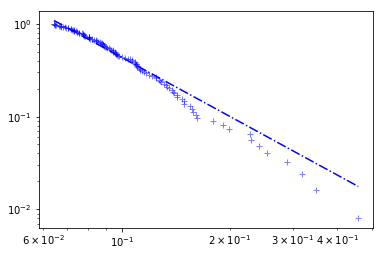

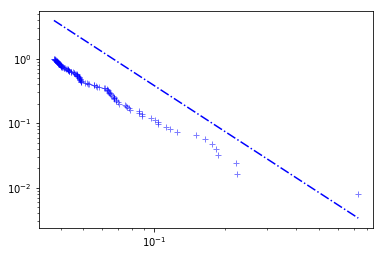

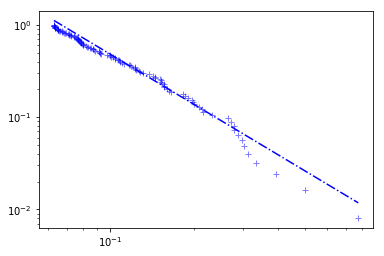

In [94]:
for col in sort_LR:
    print(f'For stock {col},')
    left_tail = sort_LR[col][sort_LR[col] < HS_var_ES(sort_LR[col], 0.95, 0.95, 0.95)]
    tail_expo_powerlaw(left_tail)

## Q4

In [95]:
def resample(data, days=5):
    data = np.asarray(data)
    resampled = np.zeros(int(len(data)/days))
    j = days
    for i in range(len(resampled)):
        resampled[i] = sum(data[j-days:j])
        j = j + days
    return resampled

#input is daily log return series

In [99]:
Yearly = pd.DataFrame(columns=logR.columns, dtype=float)

for col in logR:
    Yearly[col] = resample(logR[col], days=250)
Yearly.reset_index(inplace=True, drop=True)

In [102]:
sort_LRY = pd.DataFrame(columns=Yearly.columns, dtype=float)

for col in logR:
    sort_LRY[col] = Yearly[col].sort_values().values
sort_LRY.reset_index(inplace=True, drop=True)

In [107]:
def HS_var_ESY(data, alpha_one, alpha_two, alpha_es):
    ind_var_one = int( data.size * (1-alpha_one))
    ind_var_two = int( data.size * (1-alpha_two))
    ind_es = int( data.size * (1-alpha_es))-1
    HS_var_ones = data[ind_var_one]
    HS_var_twos = data[ind_var_two]
    HS_ES = data[:ind_es+1].mean()
    
    print(f'Historical 5% Var is : {HS_var_ones}')
    #print(f'Historical {alpha_two * 100}% Var is : {HS_var_twos}')
    #print(f'Historical {alpha_es * 100}% ES is : {HS_ES}')

    return HS_var_ones

#In put is sorted (accending) log returns, when calculating var and ES, using floor of the index (size * alpha)

#example for sorting

#sortedreturn = np.asarray(np.sort(re20))
#sortedreturn = np.asarray(logR.sort_values())


## Diff : var index defined as cap of size*alpha

In [117]:
for col in sort_LR:
    print(f'For stock {col} yearly return')
    HS_var_ESY(sort_LRY[col], 0.95, 0.95, 0.95)

For stock S1 yearly return
Historical 5% Var is : -1.8605826910411751
For stock S2 yearly return
Historical 5% Var is : -0.9472265321626683
For stock S3 yearly return
Historical 5% Var is : -1.7044290620873686


For stock S1 daily return,
Historical 5% Var is : -0.06415930785472801
For stock S2 daily return,
Historical 5% Var is : -0.03722934176835602
For stock S3 daily return,
Historical 5% Var is : -0.06178435253208292

In [113]:
VarScaled_S1 = 250 ** (1/2.093595854216556) * (-0.06415930785472801)
print(f'Scaled yearly Var for S1 is {VarScaled_S1}')

Scaled yearly Var for S1 is -0.8966620198893082


In [115]:
VarScaled_S2 = 250 ** (1/2.377002203068422) * (-0.03722934176835602)
print(f'Scaled yearly Var for S2 is {VarScaled_S2}')

Scaled yearly Var for S2 is -0.3799214814641398


In [116]:
VarScaled_S3 = 250 ** (1/1.809218385527358) * (-0.06178435253208292)
print(f'Scaled yearly Var for S3 is {VarScaled_S3}')

Scaled yearly Var for S3 is -1.307012025597282


Scaled Var have lower absolute value means they are not as save as HS ones. However we can see that the lower the tail exponents, the fatter tail it predict, and the higher losee it indicates, e.g. S3

## Q5

In [118]:
logR.describe().iloc[:3]

,S1,S2,S3
count,2499.000000,2499.000000,2499.000000
mean,0.000206,-0.000182,-0.000565
std,0.045696,0.031346,0.054522


In [119]:
for col in logR:
    a = logR[col]
    print(f'Log likelyhood for stock {col} :')
    b = np.log(stats.norm.pdf(a, loc = np.mean(a), scale = np.std(a))).sum()
    print(b)

Log likelyhood for stock S1 :
4165.871528980833
Log likelyhood for stock S2 :
5107.753686042131
Log likelyhood for stock S3 :
3724.5310269669044


## Q6

## Q7

In [120]:
corrcoeff = logR.corr()
corrcoeff

,S1,S2,S3
S1,1.000000,0.196510,0.297266
S2,0.196510,1.000000,0.238568
S3,0.297266,0.238568,1.000000


Most correlated pair is S1 and S3 with correlation 0.297266

In [124]:
KenTau = logR.corr(method='kendall')
KenTau

,S1,S2,S3
S1,1.000000,0.204007,0.248653
S2,0.204007,1.000000,0.263681
S3,0.248653,0.263681,1.000000


In [125]:
spearmanRank = logR.corr(method='spearman')
spearmanRank

,S1,S2,S3
S1,1.000000,0.294712,0.347430
S2,0.294712,1.000000,0.374042
S3,0.347430,0.374042,1.000000


These two agreed with that most correlated pair is S2 and S3 which are diff form Pearson.
Potential reasons are 1) These two capture non-linear correlations that Pearson does not capture
2) these two capture only monotonic correlations


For all three type of correlations, all correlations are positive

## Q8

In [133]:
R_Port = logR['S1'] - 0.297266 * (0.045696 / 0.054522) * logR['S3']

print('Mean return of this portfolio is ')
np.mean(R_Port)

Mean return of this portfolio is 


0.00034691440498137827

In [134]:
SortPort = R_Port.sort_values().reset_index(drop=True)

In [136]:
SortPort

0      -0.458405
1      -0.336894
2      -0.279572
3      -0.243253
4      -0.219205
5      -0.218581
6      -0.216567
7      -0.204693
8      -0.189592
9      -0.171364
10     -0.168541
11     -0.167035
12     -0.164339
13     -0.162952
14     -0.159540
15     -0.158301
16     -0.151918
17     -0.149789
18     -0.140624
19     -0.140105
20     -0.134969
21     -0.131436
22     -0.131292
23     -0.131154
24     -0.130966
25     -0.128006
26     -0.126725
27     -0.124037
28     -0.123290
29     -0.123143
          ...   
2469    0.115284
2470    0.117585
2471    0.117822
2472    0.119394
2473    0.121088
2474    0.122997
2475    0.124338
2476    0.125237
2477    0.127945
2478    0.129148
2479    0.129395
2480    0.129438
2481    0.131391
2482    0.141639
2483    0.145360
2484    0.149205
2485    0.154092
2486    0.159307
2487    0.160251
2488    0.162897
2489    0.166323
2490    0.169750
2491    0.182962
2492    0.208313
2493    0.212509
2494    0.218125
2495    0.278788
2496    0.2901

In [140]:
print('For portfolio,')
c = HS_var_ES(SortPort, 0.95, 0.95, 0.95)


For portfolio,
Historical 5% Var is : -0.05816242305521469


For stock S1,
Historical 5% Var is : -0.06415930785472801

Confirmed the portfolio has lower absolute value of Var5%

In [ ]:
def bootstrap_test(data, method='pearson', times=1000):
    
    realCorr = data.corr(method=method)
    print(realCorr)
    permuted = pd.DataFrame(columns=data.columns, dtype=float)
    counts = pd.DataFrame(np.zeros((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns, dtype=float)
    minCorr = pd.DataFrame(np.ones((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns, dtype=float)
    maxCorr = pd.DataFrame(np.zeros((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns, dtype=float)

    for i in ['S1', 'S3']:
        one_update = pd.DataFrame(np.zeros((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns, dtype=float)

        for col in data:
            permuted[col] = data[col].sample(frac=1, replace=True).reset_index(drop=True)
        ranCorr = permuted.corr(method = method)

        for col in ranCorr:
            for ref_col in ranCorr:
                if ranCorr[col][ref_col] > realCorr[col][ref_col]:
                    one_update[col][ref_col] = 1
                if ranCorr[col][ref_col] < minCorr[col][ref_col]:
                    minCorr[col][ref_col] = ranCorr[col][ref_col]
                if ranCorr[col][ref_col] > maxCorr[col][ref_col]:
                    maxCorr[col][ref_col] = ranCorr[col][ref_col]
                    
        #print(one_update)
        counts = counts + one_update
        
    return counts/times, maxCorr, minCorr

    

In [ ]:
def bootstrap_test(data, method='pearson', times=1000):
    Boot = pd.DataFrame(columns=data.columns, dtype=float)
    for col in ['S1', 'S3']:
        Boot[col] = data[col].sample(frac=1, replace=True).reset_index(drop=True)
    R_Port = data['S1'] - Boot.corr()['S1']['S3'] * (np.std(data['S1']) / np.std(data['S2'])) * data['S3']

